## Final Project Submission

Please fill out:
* Student name: Terry Thompson
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Matt Carr
* Blog post URL:https://www.blogger.com/blog/post/edit/394033909374120085/5566861248363402941


# <div align="center"><b> King County Housing Data </b></div>

#### I will be looking at ways for homeowners to increase their property value in King County, Washington.  Below we will look at the King County Washington housing dataset to build a model that will ascertain which aspects of property improvement would be the best choices for homeowners.  

In [211]:
# Import necessary tools, take a look at the data.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import numpy as np
import pandas as pd
pd.read_csv('kc_house_data.csv')
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [212]:
#check dataset shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [213]:
# Check for NaNs
for column in df.columns:
    num_of_nan = (sum(df[column].isnull()) / len(df[column])) * 100
    print(column, num_of_nan)

id 0.0
date 0.0
price 0.0
bedrooms 0.0
bathrooms 0.0
sqft_living 0.0
sqft_lot 0.0
floors 0.0
waterfront 11.00152798999861
view 0.29170718155299347
condition 0.0
grade 0.0
sqft_above 0.0
sqft_basement 0.0
yr_built 0.0
yr_renovated 17.78950780200954
zipcode 0.0
lat 0.0
long 0.0
sqft_living15 0.0
sqft_lot15 0.0


###### The waterfront and view columns need to be filled.  The yr_renovated column will be dropped.  

In [214]:
df.waterfront.fillna(0.0, inplace=True)
df.view.fillna(0.0, inplace=True)

In [215]:
df.waterfront.value_counts()

NO     19075
0.0     2376
YES      146
Name: waterfront, dtype: int64

In [216]:
df['waterfront'] = df['waterfront'].replace(['NO', 0.0, 'YES'], [0, 0, 1])

In [217]:
df.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
0.0             63
Name: view, dtype: int64

In [218]:
df['view'] = df['view'].replace(['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT', 0.0], [0, 1, 2, 3, 4, 0])

In [219]:
df.view.value_counts()

0    19485
1      957
2      508
3      330
4      317
Name: view, dtype: int64

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

###### Since the goal of the project is to provide homeowners with ways they can increase the values of their homes, we will remove columns that homeowners cannot change, such as latitude and longitude.

In [221]:
df.drop(['id', 'date', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'], axis=1, inplace=True)

###### The basement column will need to be cleaned.

In [222]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2250.0        1
1008.0        1
283.0         1
4820.0        1
1913.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [223]:
df['sqft_basement'] = df.sqft_basement.replace('?', 0.0).astype('float')
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

###### The condition and grade columns have non numeric values, and will need to be cleaned.

In [224]:
df['condition'] = df['condition'].replace(['Poor', 'Fair', 'Average', 'Good', 'Very Good'], ['1', '2', '3', '4', '5']).astype('int64')
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [225]:
df['grade'] = df['grade'].replace(['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average',
                                   '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion'],
                                  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']).astype('int64')
df.grade.value_counts()

5     8974
6     6065
7     2615
4     2038
8     1134
9      399
3      242
10      89
2       27
11      13
1        1
Name: grade, dtype: int64

###### In order to make use of the floor data, it will need to be rounded to the nearest whole floor.

In [226]:
df.floors = np.ceil(df.floors).astype('int64')

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  int64  
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.3 MB


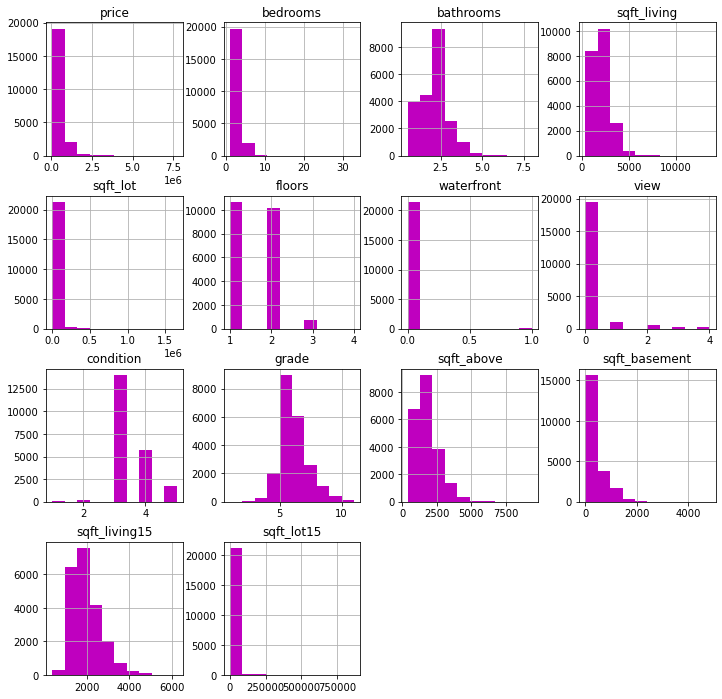

In [228]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df.hist(ax = ax, color = 'm');

###### We will now check for relationship between the features and price.  This will give us an idea as to what has a clear relationship, as well as features we may need to assess further.

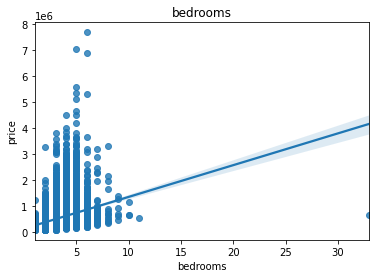

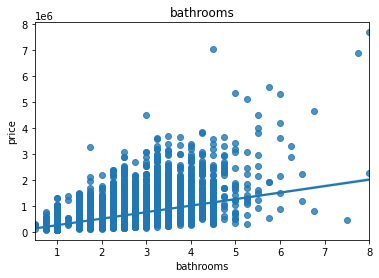

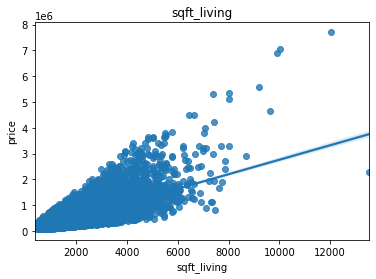

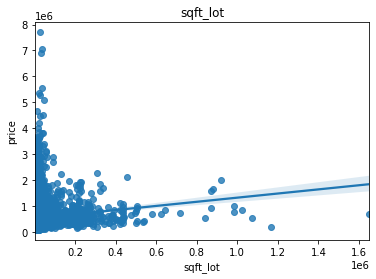

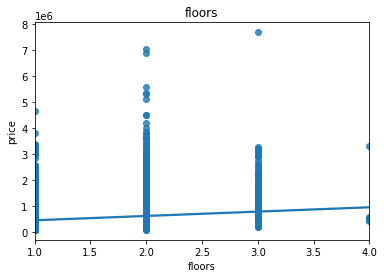

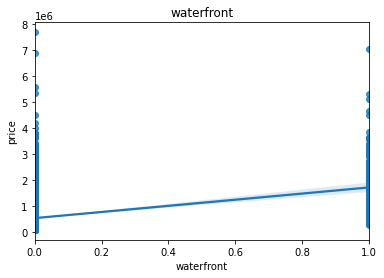

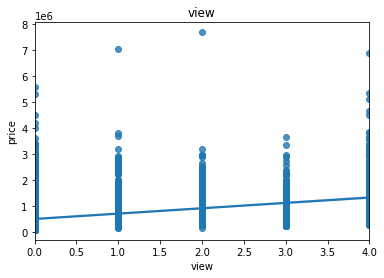

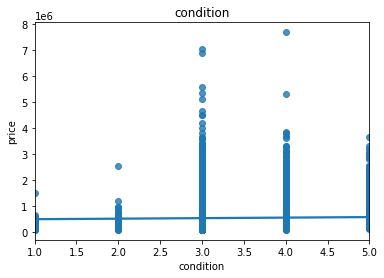

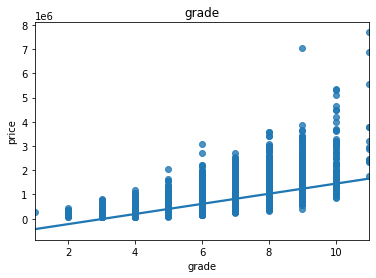

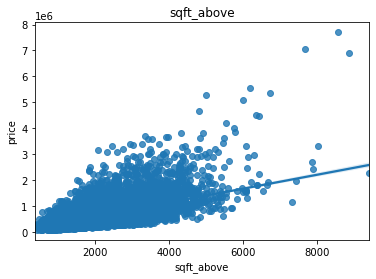

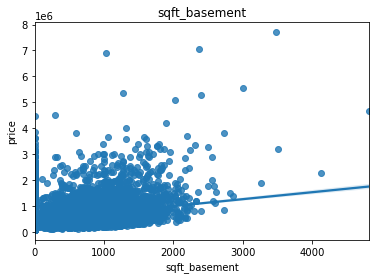

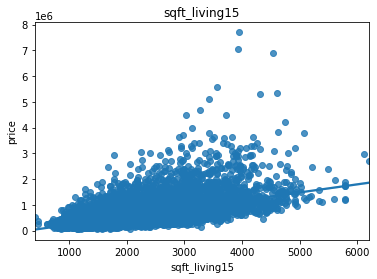

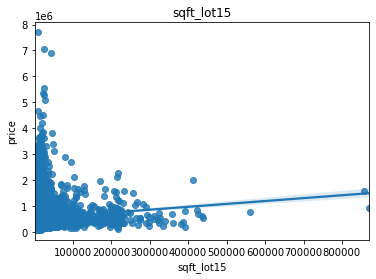

In [229]:
X = df.drop(columns=['price'], axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)

###### We will now check for multicollinearity using a heatmap.

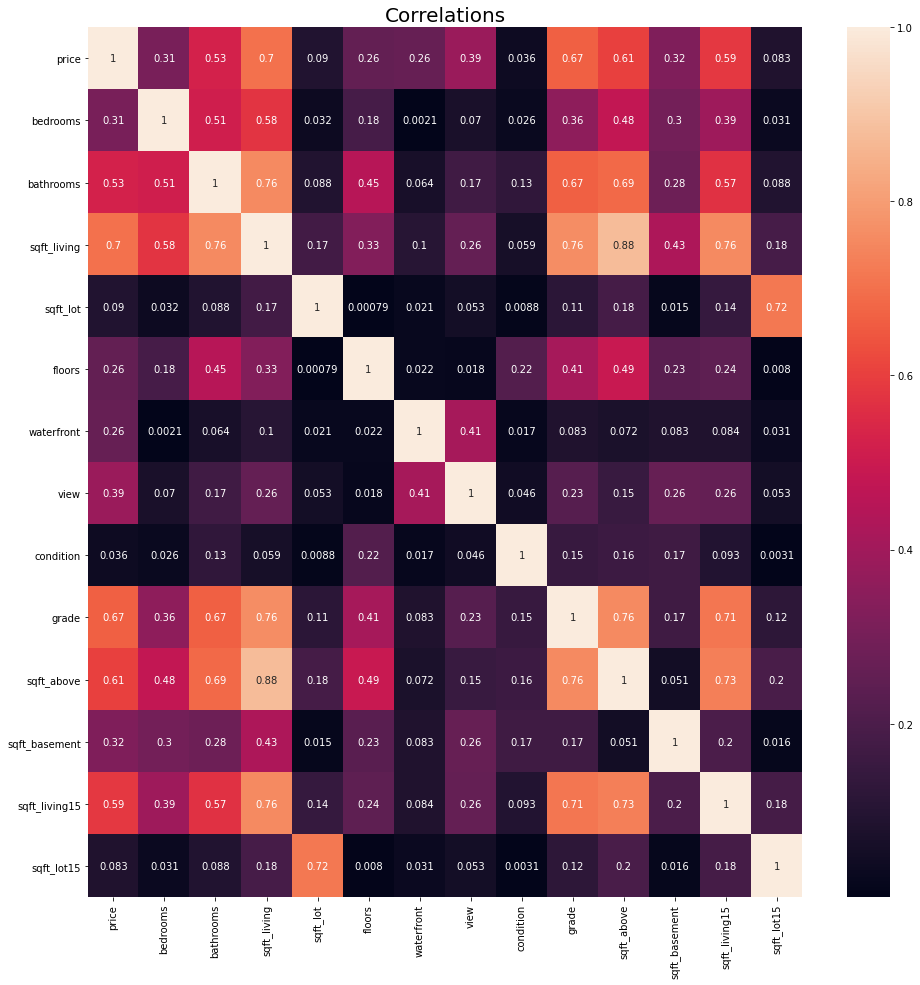

In [230]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize = (16,16))
plt.title('Correlations', fontsize = 20, y = 1)
heatmap = sns.heatmap(corr, annot = True)
heatmap;

In [231]:
features = []
correlations = []
for idx, correlation in corr['price'].iteritems():
    if correlation >= .30 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Correlations':correlations, 'Features': features}).sort_values(['Correlations'],
                                                                                              ascending = False)

In [232]:
multico_features = []
multico_corr = []
def check_multico(feature):
    for idx, correlation in corr[feature].iteritems():
        if correlation >= .80 and idx != feature:
            multico_features.append([feature, idx])
            multico_corr.append(correlation)

print('Correlations with Price')
display(corr_price_df)

Correlations with Price


,Correlations,Features
2,0.701917,sqft_living
4,0.667951,grade
5,0.605368,sqft_above
7,0.585241,sqft_living15
1,0.525906,bathrooms
3,0.386430,view
6,0.321108,sqft_basement
0,0.308787,bedrooms


###### Here we have a list of features that correlate well with price.

In [233]:
for feature in corr:
    check_multico(feature)
multi_df = pd.DataFrame({'Correlations':multico_corr, 'Features': multico_features}).sort_values(['Correlations'],
                                                                                                 ascending = False)
print('Multicollinear Features')
display(multi_df)

Multicollinear Features


,Correlations,Features
0,0.876448,"[sqft_living, sqft_above]"
1,0.876448,"[sqft_above, sqft_living]"


###### Here we can see that there is a strong multicollinearity between sqft_living and sqft_above.  We will drop sqft_above.

In [234]:
df.drop(['sqft_above'], axis = 1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1,0,0,3,5,0.0,1340,5650
1,538000.0,3,2.25,2570,7242,2,0,0,3,5,400.0,1690,7639
2,180000.0,2,1.00,770,10000,1,0,0,3,4,0.0,2720,8062
3,604000.0,4,3.00,1960,5000,1,0,0,5,5,910.0,1360,5000
4,510000.0,3,2.00,1680,8080,1,0,0,3,6,0.0,1800,7503


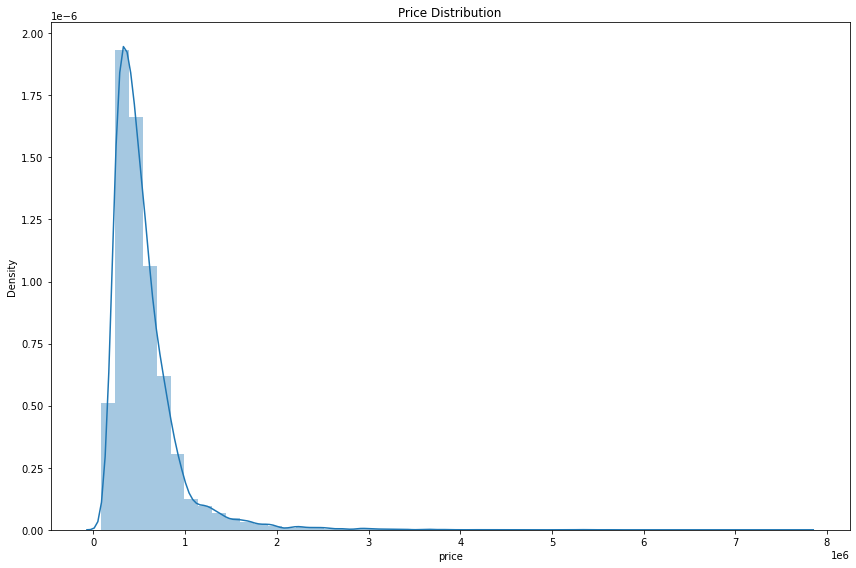

In [236]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()

###### Here we see that the price variable is skewed.  We will have to check for outliers and remove them.

In [237]:
data = df['price']
mean = np.mean(data)
std = np.std(data)
print('mean of the dataset is', mean)
print('std. deviation is', std)

mean of the dataset is 540296.5735055795
std. deviation is 367359.634929548


In [238]:
threshold = 3
outlier = []
for i in data:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [2000000.0, 2250000.0, 2400000.0, 2900000.0, 2050000.0, 3080000.0, 2380000.0, 2250000.0, 2130000.0, 1950000.0, 3070000.0, 2250000.0, 2400000.0, 2450000.0, 1960000.0, 1750000.0, 5110000.0, 1880000.0, 2300000.0, 2260000.0, 5300000.0, 2200000.0, 1700000.0, 2540000.0, 5350000.0, 2250000.0, 1680000.0, 1930000.0, 2350000.0, 1720000.0, 2400000.0, 2530000.0, 3850000.0, 1740000.0, 1700000.0, 1650000.0, 1680000.0, 1760000.0, 2750000.0, 1810000.0, 3280000.0, 1700000.0, 1870000.0, 1650000.0, 4500000.0, 1840000.0, 3600000.0, 3000000.0, 2950000.0, 2530000.0, 1800000.0, 2300000.0, 2290000.0, 1900000.0, 1900000.0, 1900000.0, 1970000.0, 1680000.0, 2080000.0, 2540000.0, 2100000.0, 2450000.0, 2450000.0, 1910000.0, 1740000.0, 1650000.0, 2890000.0, 2200000.0, 2950000.0, 7060000.0, 2400000.0, 2500000.0, 2150000.0, 4000000.0, 2880000.0, 1880000.0, 2400000.0, 2130000.0, 2050000.0, 1710000.0, 5570000.0, 1670000.0, 2000000.0, 2490000.0, 1850000.0, 2480000.0, 2050000.0, 1900000.0, 1940000.0

In [239]:
print(min(outlier))

1650000.0


###### Now that we have a minimum value for our outliers, we can remove them from the data.

In [240]:
df = df[df['price'] <= 1650000]

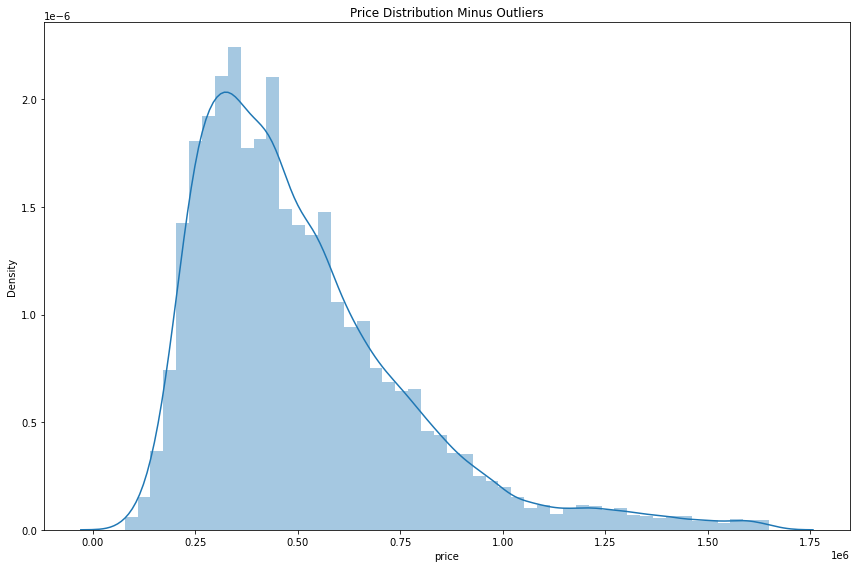

In [241]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution Minus Outliers')
plt.tight_layout()

###### After removing the outliers, our curve is better, but still skewed to the left.  We will use this going forward.

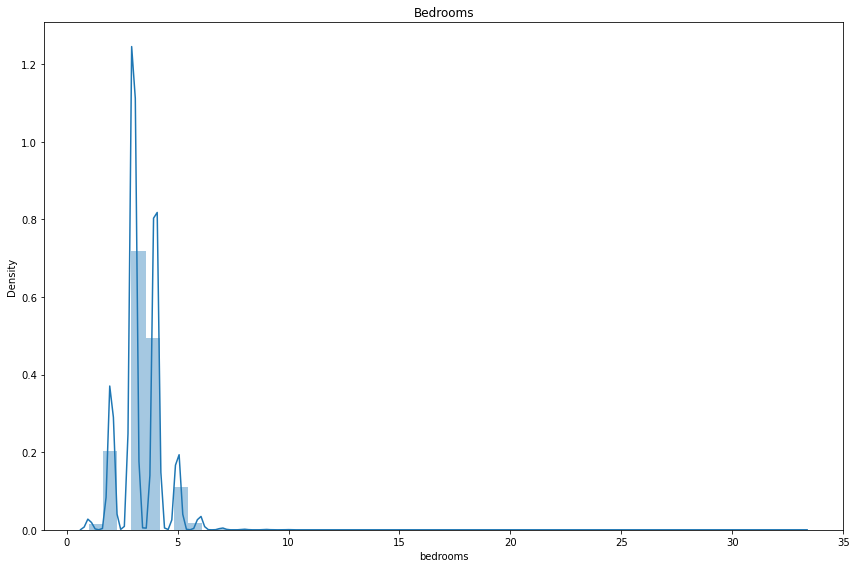

In [243]:
plt.figure(figsize=(12, 8))
sns.distplot(df.bedrooms)
plt.title('Bedrooms')
plt.tight_layout()

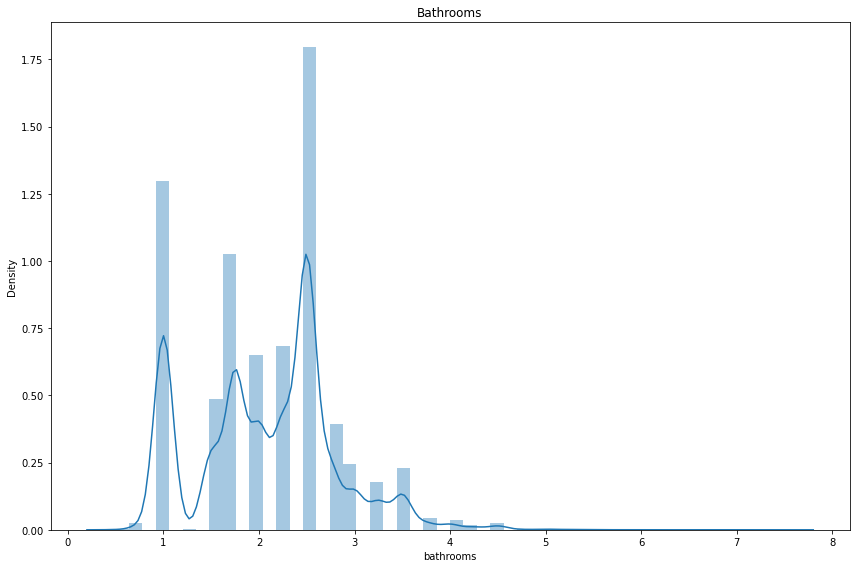

In [245]:
plt.figure(figsize=(12, 8))
sns.distplot(df.bathrooms)
plt.title('Bathrooms')
plt.tight_layout()

###### We also have outliers in bathrooms and bedrooms.  We will find and eliminate them from the data.

In [246]:
data = df['bedrooms']
mean = np.mean(data)
std = np.std(data)
print('mean of the dataset is', mean)
print('std. deviation is', std)

mean of the dataset is 3.356816145612298
std. deviation is 0.9180853759793801


In [247]:
threshold = 3
outlier = []
for i in data:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [7, 7, 8, 7, 7, 8, 9, 9, 7, 7, 7, 9, 8, 7, 7, 7, 9, 7, 11, 8, 7, 8, 7, 7, 7, 7, 8, 7, 7, 7, 7, 8, 7, 10, 7, 7, 8, 10, 7, 8, 7, 33, 7, 7, 9, 7, 9, 7, 7, 7, 10, 8, 7]


In [248]:
print(min(outlier))

7


In [249]:
data = df['bathrooms']
mean = np.mean(data)
std = np.std(data)
print('mean of the dataset is', mean)
print('std. deviation is', std)

mean of the dataset is 2.088308105814118
std. deviation is 0.7364703165298392


In [250]:
threshold = 3
outlier = []
for i in data:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
print('outlier in dataset is', outlier)

outlier in dataset is [4.5, 4.75, 4.5, 5.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.75, 5.0, 4.5, 5.0, 4.5, 5.0, 4.5, 4.5, 4.5, 5.5, 5.25, 4.5, 4.5, 4.5, 4.75, 4.75, 4.5, 6.75, 4.5, 4.5, 5.25, 4.75, 5.25, 4.5, 5.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 7.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.75, 4.5, 4.5, 4.5, 5.0, 5.25, 5.5, 4.5, 5.0, 4.5, 4.5, 4.5, 5.75, 4.5, 4.5, 5.0, 5.25, 4.5, 4.5, 4.5, 4.5, 5.0, 5.25, 4.5, 4.5, 5.5, 4.5, 4.5, 5.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5.5, 4.5, 6.5, 4.5, 5.25, 4.5, 5.0, 6.0, 4.5, 4.75, 6.0, 4.5, 4.5]


In [251]:
print(min(outlier))

4.5


In [252]:
df = df[df['bedrooms'] <= 7]
df = df[df['bathrooms'] <= 4.5]

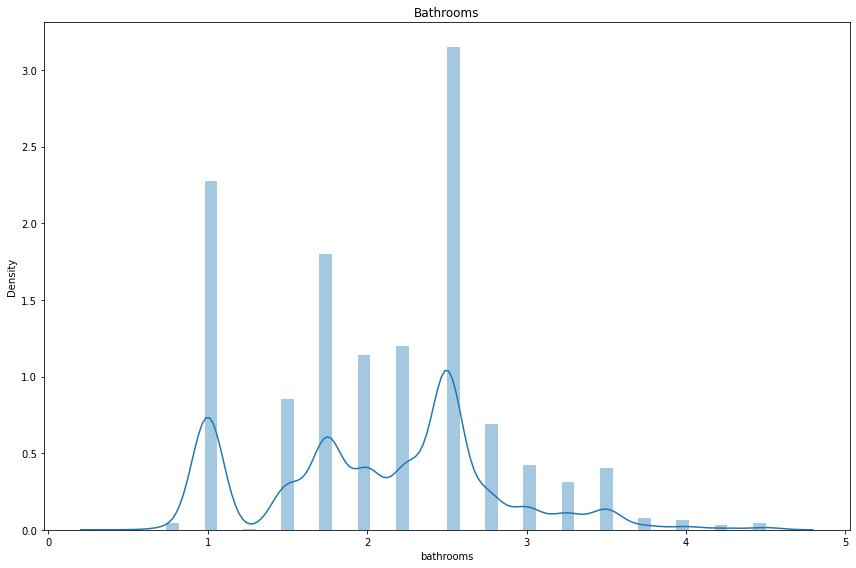

In [253]:
plt.figure(figsize=(12, 8))
sns.distplot(df.bathrooms)
plt.title('Bathrooms')
plt.tight_layout()

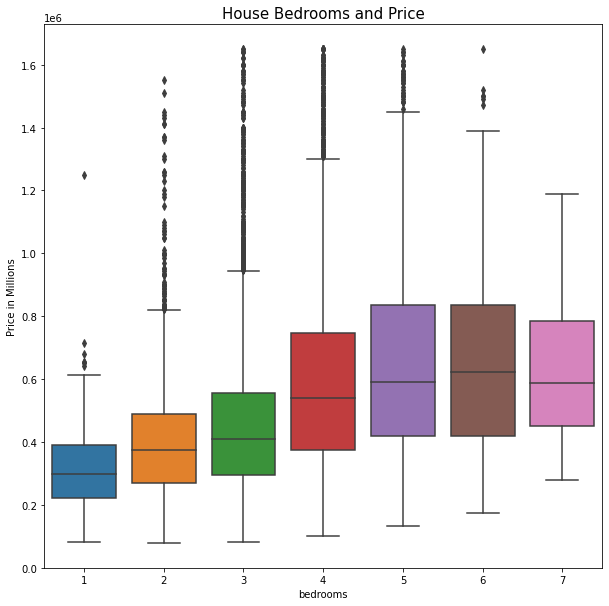

In [254]:
plt.figure(figsize = (10,10))
sns.boxplot(df['bedrooms'], df['price'])
plt.ylabel('Price in Millions')
plt.title('House Bedrooms and Price', fontsize = 15);

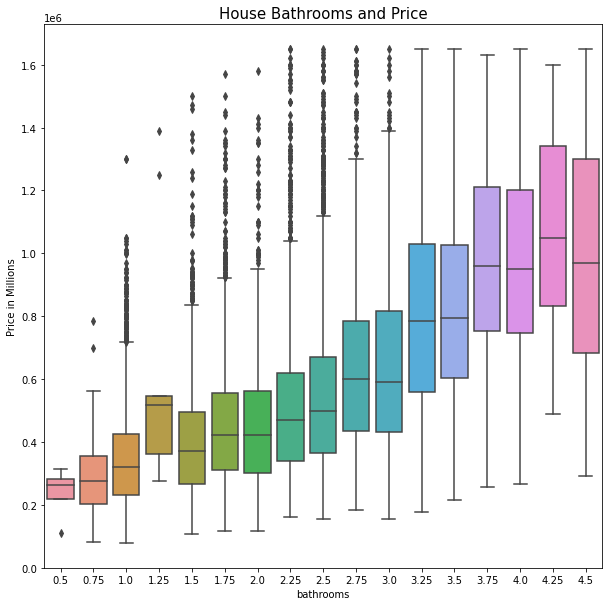

In [255]:
plt.figure(figsize = (10,10))
sns.boxplot(df['bathrooms'], df['price'])
plt.ylabel('Price in Millions')
plt.title('House Bathrooms and Price', fontsize = 15);

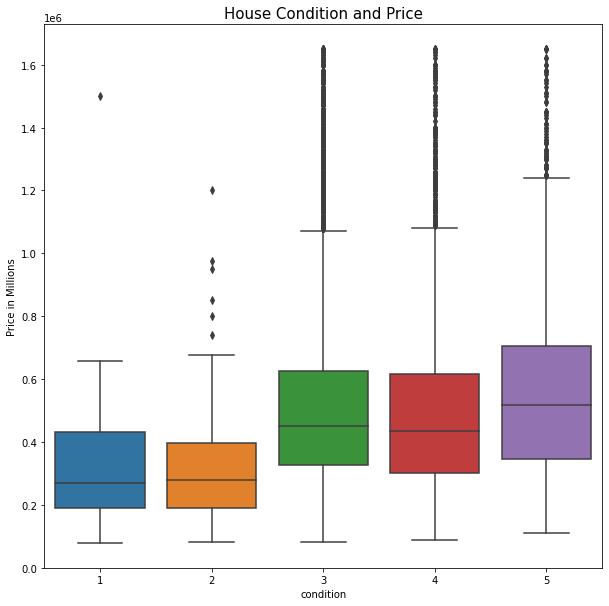

In [256]:
plt.figure(figsize = (10,10))
sns.boxplot(df['condition'], df['price'])
plt.ylabel('Price in Millions')
plt.title('House Condition and Price', fontsize = 15);

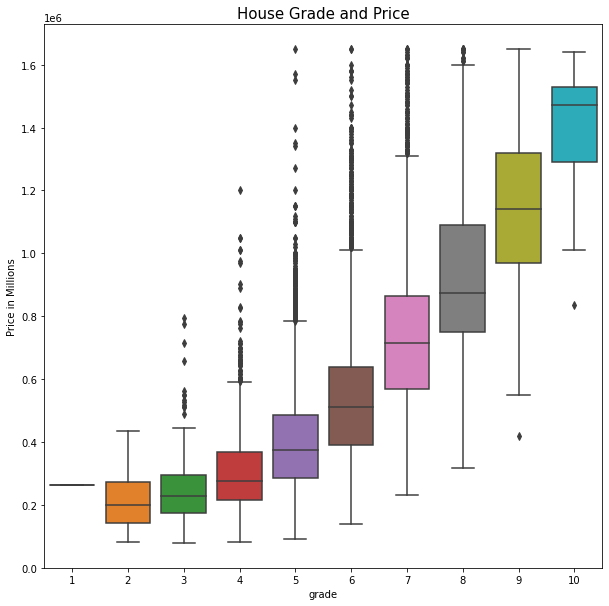

In [257]:
plt.figure(figsize = (10,10))
sns.boxplot(df['grade'], df['price'])
plt.ylabel('Price in Millions')
plt.title('House Grade and Price', fontsize = 15);

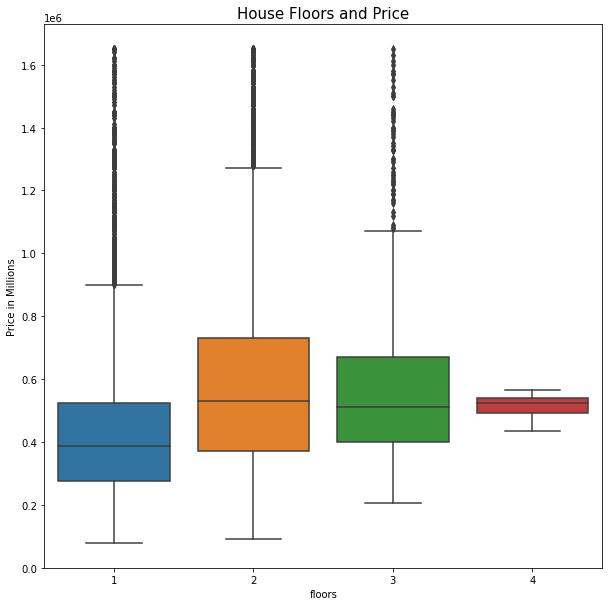

In [258]:
plt.figure(figsize = (10,10))
sns.boxplot(df['floors'], df['price'])
plt.ylabel('Price in Millions')
plt.title('House Floors and Price', fontsize = 15);

###### We will drop basements and floors from the data.

In [259]:
df.drop(['sqft_basement', 'floors'], axis=1, inplace=True)

###### Now that the data is cleaned, we will begin testing.

In [260]:
Model_1 = smf.ols(formula='price ~ grade', data=df).fit()
Model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                 1.724e+04
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:14:54   Log-Likelihood:            -2.8746e+05
No. Observations:               21153   AIC:                         5.749e+05
Df Residuals:                   21151   BIC:                         5.749e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.767e+05   6857.826    -54.926      0.000    -3.9e+05   -3.63e+05
grade       1.577e+05   1200.753    131.318      0.000    1.55e+05     1.6e+05
==============================================================================
Omnibus:                     4169.504   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9693.147
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       5.450   Cond. No.                         30.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
Model_2 = smf.ols(formula='price ~ grade + condition + view', data=df).fit()
Model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     7191.
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:14:58   Log-Likelihood:            -2.8633e+05
No. Observations:               21153   AIC:                         5.727e+05
Df Residuals:                   21149   BIC:                         5.727e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.641e+05   1.02e+04    -55.468      0.000   -5.84e+05   -5.44e+05
grade       1.555e+05   1170.971    132.794      0.000    1.53e+05    1.58e+05
condition   5.472e+04   1967.412     27.811      0.000    5.09e+04    5.86e+04
view        7.741e+04   2033.752     38.063      0.000    7.34e+04    8.14e+04
==============================================================================
Omnibus:                     3640.185   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8306.427
Skew:                           0.993   Prob(JB):                         0.00
Kurtosis:                       5.342   Cond. No.                         55.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
Model_3 = smf.ols(formula='price ~ grade + condition + view + sqft_living', data=df).fit()
Model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     6568.
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:15:00   Log-Likelihood:            -2.8523e+05
No. Observations:               21153   AIC:                         5.705e+05
Df Residuals:                   21148   BIC:                         5.705e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.324e+05      1e+04    -43.104      0.000   -4.52e+05   -4.13e+05
grade        9.842e+04   1623.770     60.612      0.000    9.52e+04    1.02e+05
condition    4.857e+04   1871.825     25.946      0.000    4.49e+04    5.22e+04
view          6.76e+04   1941.140     34.824      0.000    6.38e+04    7.14e+04
sqft_living   103.9428      2.156     48.220      0.000      99.718     108.168
==============================================================================
Omnibus:                     3438.805   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7938.641
Skew:                           0.939   Prob(JB):                         0.00
Kurtosis:                       5.341   Cond. No.                     1.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [263]:
Model_4 = smf.ols(formula='price ~ grade + condition + view + sqft_living + waterfront +sqft_lot + bedrooms + bathrooms', data=df).fit()
Model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     3347.
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:18:01   Log-Likelihood:            -2.8511e+05
No. Observations:               21153   AIC:                         5.702e+05
Df Residuals:                   21144   BIC:                         5.703e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.874e+05   1.08e+04    -35.910      0.000   -4.09e+05   -3.66e+05
grade        9.765e+04   1681.607     58.069      0.000    9.44e+04    1.01e+05
condition    4.901e+04   1874.740     26.142      0.000    4.53e+04    5.27e+04
view         5.966e+04   2059.872     28.962      0.000    5.56e+04    6.37e+04
sqft_living   125.5768      2.777     45.226      0.000     120.134     131.019
waterfront   1.723e+05   2.03e+04      8.468      0.000    1.32e+05    2.12e+05
sqft_lot       -0.1368      0.030     -4.558      0.000      -0.196      -0.078
bedrooms    -1.731e+04   1760.568     -9.834      0.000   -2.08e+04   -1.39e+04
bathrooms   -1.224e+04   2523.180     -4.851      0.000   -1.72e+04   -7294.714
==============================================================================
Omnibus:                     3445.503   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8158.935
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       5.405   Cond. No.                     7.37e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [265]:
X = df.drop(columns=['price'], axis=1)
y = df.price

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1000)

#Fit the model
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
model

#View model accuracy
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print('Training Score:', round(train_score, 2))
print('Test Score:', round(test_score, 2))
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

#View model summary in statsmodels
X_train = sm.add_constant(X_train)
smmodel = sm.OLS(y_train, X_train).fit()
smmodel.summary()

Training Score: 0.56
Test Score: 0.57
Intercept: -394777.046556345
Coefficients: [-1.56618328e+04 -9.33511391e+03  1.09059385e+02  6.62247654e-02
  1.68296262e+05  5.86726515e+04  4.93160517e+04  9.19370632e+04
  3.25455142e+01 -4.92909616e-01]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     2164.
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        21:18:37   Log-Likelihood:            -2.2807e+05
No. Observations:               16922   AIC:                         4.562e+05
Df Residuals:                   16911   BIC:                         4.562e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.948e+05   1.21e+04    -32.571      0.000   -4.19e+05   -3.71e+05
bedrooms      -1.566e+04   1975.886     -7.926      0.000   -1.95e+04   -1.18e+04
bathrooms     -9335.1139   2838.077     -3.289      0.001   -1.49e+04   -3772.188
sqft_living     109.0594      3.439     31.710      0.000     102.318     115.801
sqft_lot          0.0662      0.047      1.421      0.155      -0.025       0.158
waterfront     1.683e+05   2.25e+04      7.464      0.000    1.24e+05    2.12e+05
view           5.867e+04   2326.223     25.222      0.000    5.41e+04    6.32e+04
condition      4.932e+04   2099.798     23.486      0.000    4.52e+04    5.34e+04
grade          9.194e+04   1966.464     46.752      0.000    8.81e+04    9.58e+04
sqft_living15    32.5455      3.304      9.851      0.000      26.070      39.021
sqft_lot15       -0.4929      0.072     -6.853      0.000      -0.634      -0.352
==============================================================================
Omnibus:                     2734.951   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6463.611
Skew:                           0.925   Prob(JB):                         0.00
Kurtosis:                       5.397   Cond. No.                     8.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

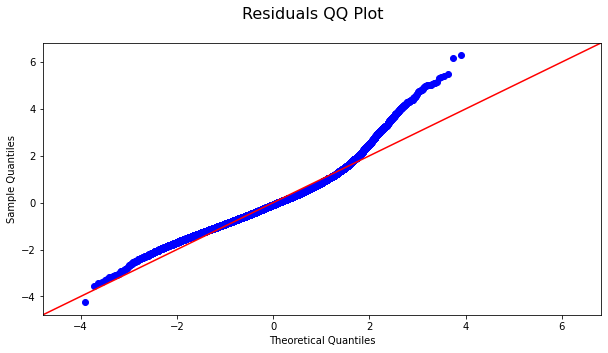

In [269]:
residuals = Model_4.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.suptitle('Residuals QQ Plot', fontsize=16)
fig.set_size_inches(10, 5)
fig.show()

In [270]:
model_coefficients = pd.DataFrame(smmodel.params[1:], columns=['coefficients'])

In [271]:
print("Final Regression Formula\n")
print(model.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')

Final Regression Formula

-394777.046556345 +
sum(
-15661.832774102948 * bedrooms
-9335.113910332122 * bathrooms
109.05938494810401 * sqft_living
0.0662247654199873 * sqft_lot
168296.26163919736 * waterfront
58672.65152792215 * view
49316.051715926405 * condition
91937.0631681071 * grade
32.54551418043456 * sqft_living15
-0.4929096155883571 * sqft_lot15
)


###### With the final regression, we can see that upgrading one unit in grade will raise the value of the home by $91,937.   

###### Upgrading the condition of the house by one unit will raise the value by $49,316.

###### Upgrading the square footage of the house by one unit will raise the value of the house by 109 dollars.  If the square footage were increase 100 square feet, the value would rise 10,905 dollars.

###### In conclusion, upgrading the grade, condition, or square footage of the house will yield the best raises in property value.  This model does have limitations though, as it does not take into account mega mansions, or multifamily housing.  Other tests should be run to ascertain the best upgrades for said housing.

######  Other factors that could be further researched would be proximity to amenities, crime rate per zipcode, and infrastructure by zipcode.